# Class definitions

In [2]:
from PIL import Image, ImageDraw

class Point(object):
    def __init__(self, x, y):
        self.p = (x, y)
        self.x = x
        self.y = y
    
    def shift(self, dx, dy):
        return Point(self.p[0] + dx, self.p[1] + dy)

    def __repr__(self):
        return "(%f, %f)" % (self.p)
    
    def coord(self, height, scale=9):
        return (scale * self.p[0], scale *(height - self.p[1]))


class Base():
    def __init__(self, width, height, scale=9, stroke=9, color=None, fill_color=None, background_color=None):
        self.width = width
        self.height = height
        self.stroke = stroke
        self.scale = scale

        if color is None:
            self.color = (0,0,0)
        else:
            self.color = color
        if fill_color is None:
            self.fill_color = (1,1,0)
        else:
            self.fill_color = fill_color

        self.im = Image.new("RGBA", (self.width*self.scale, self.height*self.scale), color=background_color)
        self.draw = ImageDraw.Draw(self.im)
        
    def boundingBox(self, p, r=None):
        if r is not None:
            return (p[0] - r, p[1] - r, p[0] + r, p[1] + r)
        
    def line(self, p1, p2, joint=None):
        coords = [p1.coord(self.height, self.scale), p2.coord(self.height, self.scale)]
        self.draw.line(coords, fill=self.color, width=self.stroke, joint=joint)

    def lines(self, *points, closed=False):
        coords = [p.coord(self.height, self.scale) for p in points]
        if closed:
            coords = coords + coords[:2]
        self.draw.line(coords, fill=self.color, width=self.stroke, joint="curve")
        
    def rectangle(self, p1, p2, outline=None):
        if outline is None:
            fill = self.color
        else:
            fill = outline
        points = [Point(p1.x, p1.y), Point(p1.x, p2.y), Point(p2.x, p2.y), Point(p2.x, p1.y)]
        self.lines(*points, closed=True)
        
    def face(self, *points, color=None):
        if color is None:
            color = self.fill_color
        coord_points = [p.coord(self.height, self.scale) for p in points]
        self.draw.polygon(coord_points, fill=self.fill_color, outline=color)

    def arc(self, p1, p2, start, end, color=None):
        if color == None:
            color = self.color
        coord_p1 = p1.coord(self.height, self.scale)
        coord_p2 = p2.coord(self.height, self.scale)
        self.draw.arc((coord_p1, coord_p2), start, end, width=self.stroke, fill=self.color)
        # shift one pixel to work around a fill bug of pillow
        self.draw.arc(((coord_p1[0]+1, coord_p1[1]), (coord_p2[0]+1, coord_p2[1])), start, end, width=self.stroke, fill=color)

    def ellipse(self, p1, p2, fill_color):
        coord_p1 = p1.coord(self.height, self.scale)
        coord_p2 = p2.coord(self.height, self.scale)
        self.draw.ellipse((coord_p1, coord_p2), fill=fill_color, outline=self.color, width = self.stroke)
        # shift one pixel to work around a fill bug of pillow
        self.draw.ellipse(((coord_p1[0]+1, coord_p1[1]), (coord_p2[0]+1, coord_p2[1])), fill=None, outline=self.color, width = self.stroke)
        
    def save(self, filename):
        self.im.save(filename)
        
    def y(self, x):
        return Point(x, int(self.height / self.width * x))


## Common definitions

In [3]:
width = 28
height = 22
scale = 10
color = (64,64,64, 255)
fill_color = (255, 204, 64)
fill_color = (243, 156, 18)
fill_color = (52, 152, 219)
fill_color = (93, 173, 226)
fill_color = (67, 127, 180) # cadquery logo blue - too dark for icons
fill_color = (76, 144, 204) # slightly brighter
fill_color = (83, 160, 227)
background_color = (255,100,0,50)

## Cube view icons

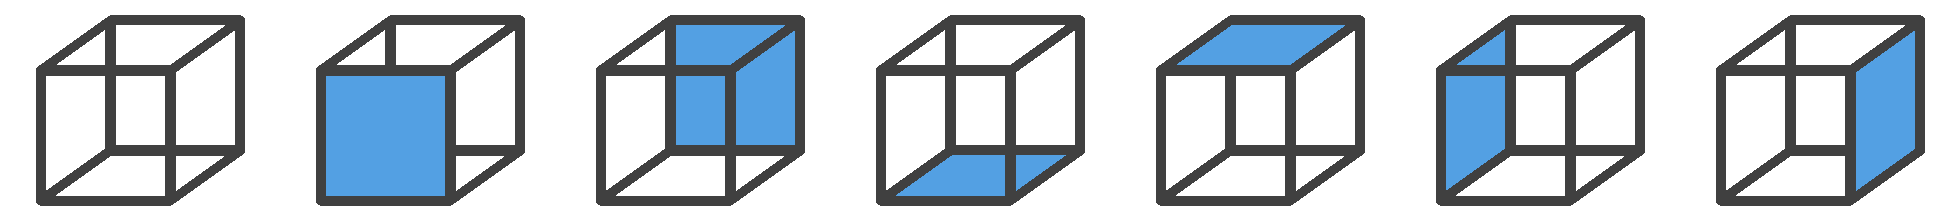

In [4]:
class Cube(Base):
    
    def __init__(self, width, height, scale=9, stroke=9, color=None, fill_color=None, background_color=None):
        super().__init__(width, height, scale, stroke, color, fill_color, background_color)
        
    def create(self, face):
        r = 13
        dx = 7
        dy = 5
        f00 = Point(4,2)
        f01 = f00.shift(0,r)
        f10 = f00.shift(r,0)
        f11 = f00.shift(r,r)
        b00 = f00.shift(dx, dy)
        b01 = b00.shift(0,r)
        b10 = b00.shift(r,0)
        b11 = b00.shift(r,r)

        if face == "rear":
            self.face(b00, b10, b11, b01)
        self.lines(b00, b10, b11, b01, closed=True) # rear
        
        if face == "bottom":
            self.face(f00, f10, b10, b00)
        if face == "right":
            self.face(f00, b00, b01, f01)

        self.lines(f00, f10, b10, b00, closed = True) # bottom
        self.lines(f00, b00, b01, f01, closed=True)   # right

        if face == "left":
            self.face(f10, b10, b11, f11)
        if face == "top":
            self.face(f01, f11, b11, b01)
        if face == "front":
            self.face(f00, f10, f11, f01)

        self.lines(f10, b10, b11, f11, closed=True) # left
        self.lines(f01, f11, b11, b01, closed=True) # top
        self.lines(f00, f10, f11, f01, closed=True) # front
        
        return self.im


new_im = Image.new('RGBA', (7 * width*scale, height*scale))
x_offset = 0

for face in ["edges", "front", "rear", "bottom", "top", "right", "left"]:
    c = Cube(width, height, scale, stroke=scale, fill_color=fill_color, color=color, background_color=None)
    c.create(face)
    new_im.paste(c.im, (x_offset,0))
    x_offset += c.im.size[0]
    c.save("./icons/%s.png" % face)

new_im


## Isometric view icon

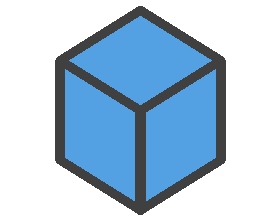

In [5]:
import math

class Isom(Base):
    def __init__(self, width, height, scale=9, stroke=9, color=None, fill_color=None, background_color=None):
        super().__init__(width, height, scale, stroke, color, fill_color, background_color)
        
    def create(self):
        x0 = 6
        r = 10
        dy = r/2
        dx = int(r*math.cos(math.pi/6))

        f00 = Point(x0, 1 + dy)
        f01 = f00.shift(0,r)
        f10 = Point(x0 + dx, 1)
        f11 = f10.shift(0,r)
        f12 = f11.shift(0,r)
        f20 = f00.shift(2*dx,0)
        f21 = f20.shift(0,r)
        
        self.line(f10, f12)
        self.lines(f00, f01, f12, f11)
        self.face(f00, f01, f11, f10)
        self.face(f10, f11, f21, f20)
        self.face(f01, f11, f21, f12)
        self.lines(f00, f01, f11, f10, closed=True)
        self.lines(f10, f11, f21, f20, closed=True)
        self.lines(f01, f11, f21, f12, closed=True)

        return self.im


c = Isom(width, height, scale, stroke=scale, fill_color=fill_color, color=color, background_color=None)
c.create()
c.save("./icons/isometric.png")
c.im


# Reset Icon

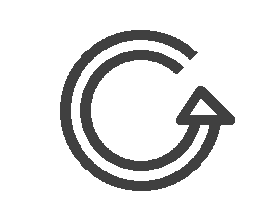

In [6]:
class Reset(Base):
    def __init__(self, width, height, scale=9, stroke=9, color=None, fill_color=None, background_color=None):
        super().__init__(width, height, scale, stroke, color, fill_color, background_color)
        
    def create(self):
        R = 7
        c00 = Point(self.width // 2 - (R - 1), self.height // 2 + (R - 1))
        c01 = Point(self.width // 2 + (R - 1), self.height // 2 - (R - 1))
        c20 = Point(self.width // 2 - (R + 1), self.height // 2 + (R + 1))
        c21 = Point(self.width // 2 + (R + 1), self.height // 2 - (R + 1))
        
        a1 = 6
        a2 = -45


        self.arc(c00, c01, a1, a2)
        self.arc(c20, c21, a1, a2)
        
        x1 = Point(self.width/2 + R - 3, self.height/2 - 1)
        x2 = Point(self.width/2 + R - 1, self.height/2 + 2)
        x3 = Point(self.width/2 + R + 2, self.height/2 - 1)
        self.lines(x1, x2, x3, closed=True)

        return self.im

      
c = Reset(width, height, scale, stroke=scale, fill_color=fill_color, color=color, background_color=None)
c.create()

c.save("./icons/reset.png")
c.im


## Fit icon

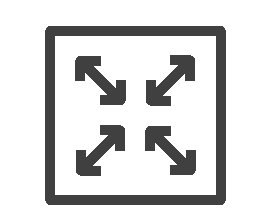

In [7]:
class Fit(Base):
    def __init__(self, width, height, scale=9, stroke=9, color=None, fill_color=None, background_color=None):
        super().__init__(width, height, scale, stroke, color, fill_color, background_color)
        
    def create(self):
        S2 = 4
        P = 2
        l = 4
        x0 = 8
        y0 = 5

        b00 = Point(x0 - 3, y0 - 3)
        b01 = Point(x0 - 3, self.height - 3)
        b10 = Point(self.width - 6, y0 - 3)
        b11 = Point(self.width - 6, self.height - 3)
        f00 = Point(x0, y0)
        g00 = f00.shift(l, l)

        f01 = Point(x0, self.height - y0 - 1)
        g01 = f01.shift(l, -l)

        f10 = Point(self.width - x0 - 1, y0)
        g10 = f10.shift(-l, l)

        f11 = Point(self.width - x0 - 1, self.height - y0 - 1)
        g11 = f11.shift(-l, -l)
        
        #self.face(b00, b01, b11, b10)
        self.rectangle(b00, b11)

        self.line(f00, g00)
        self.line(f01, g01)
        self.line(f10, g10)
        self.line(f11, g11)

        self.lines(f00.shift(0,  P), f00, f00.shift( P, 0))
        self.lines(g00.shift(0, -P), g00, g00.shift(-P, 0))

        self.lines(f01.shift(0,-P), f01, f01.shift( P, 0))
        self.lines(g01.shift(0, P), g01, g01.shift(-P, 0))

        self.lines(f10.shift(0,  P), f10, f10.shift(-P, 0))
        self.lines(g10.shift(0, -P), g10, g10.shift( P, 0))

        self.lines(f11.shift(0, -P), f11, f11.shift(-P, 0))
        self.lines(g11.shift(0,  P), g11, g11.shift( P, 0))

        return self.im


c = Fit(width, height, scale, stroke=scale, fill_color=fill_color, color=color, background_color=None)
c.create()
c.save("./icons/fit.png")
c.im


## Visiblity icon

In [8]:
class Triangle(Base):
    def __init__(self, width, height, scale=9, stroke=9, color=None, fill_color=None, background_color=None):
        super().__init__(width, height, scale, stroke, color, fill_color, background_color)
        
    def create(self, upper=True):
        f00 = Point(0,0)
        f01 = Point(0, height)
        f11 = Point(width, height)
        f10 = Point(width, 0)
        if upper:
            self.face(f00.shift(0,1), f01, f11.shift(-1,0))
        else:
            self.face(f00.shift(3,0), f10, f11.shift(3,0))

class Mask(Base):
    def __init__(self, width, height, scale=9, stroke=9, color=None, fill_color=None, background_color=None):
        super().__init__(width, height, scale, stroke, color, fill_color, background_color)
        
    def create(self, left=True):
        f00 = Point(0,0)
        f01 = Point(0, height)
        f10 = Point(width//2, 0)
        f11 = Point(width//2, height)
        f20 = Point(width, 0)
        f21 = Point(width, height)
        if left:
            self.face(f00, f01, f11.shift(0,0), f10.shift(0,0))
        else:
            self.face(f10.shift(2,0), f11.shift(2,0), f21, f20)

mask1 = Mask(width, height, scale, stroke=scale, fill_color=(255,255,255), color=(255,255,255), background_color=None)
mask1.create(True)
new_im.paste(mask1.im, (x_offset,0))
x_offset += mask1.im.size[0]

mask2 = Mask(width, height, scale, stroke=scale, fill_color=(255,255,255), color=(255,255,255), background_color=None)
mask2.create(False)
new_im.paste(mask2.im, (x_offset,0))
x_offset += mask2.im.size[0]

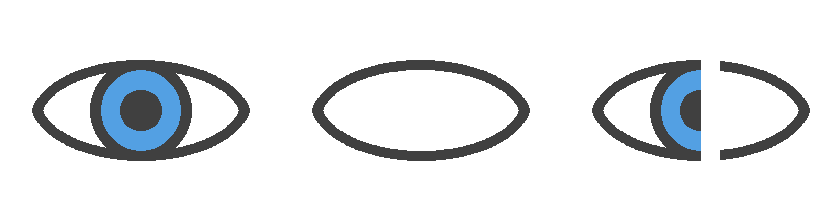

In [9]:
class Visible(Base):

    def __init__(self, width, height, scale=9, stroke=9, color=None, fill_color=None, background_color=None):
        super().__init__(width, height, scale, stroke, color, fill_color, background_color)
        
    def create(self, visible=True):
        P = 1
        R = 5
        b00 = Point(3, self.height - 5)
        b11 = Point(self.width - 3, 5)
        c00 = Point(self.width // 2 - R, self.height // 2 + R)
        c11 = Point(self.width // 2 + R, self.height // 2 - R)
        p00 = Point(self.width // 2 - 2, self.height // 2 + 2)
        p11 = Point(self.width // 2 + 2, self.height // 2 - 2)

        self.arc(b00.shift(0,-P), b11.shift(0,-P), -170, -10)
        self.arc(b00.shift(0, P), b11.shift(0, P), 10, 170)

        if visible:
            self.ellipse(c00, c11, fill_color=fill_color)
            self.ellipse(p00, p11, fill_color=color)
            self.ellipse(p00, p11, fill_color=color)
        return self.im


new_im = Image.new('RGBA', (3 * width*scale, height*scale))
x_offset = 0
c = {}
for visible in ["shape", "no_shape"]:
    c[visible] = Visible(width, height, scale, stroke=scale, fill_color=fill_color, color=color, background_color=None)
    c[visible].create(visible == "shape")
    new_im.paste(c[visible].im, (x_offset,0))
    x_offset += c[visible].im.size[0]
    c[visible].save("./icons/%s.png" % visible)

mixed = Image.new('RGBA', (width*scale, height*scale))
mixed.paste(c["shape"].im, (0,0), mask=mask1.im)
mixed.paste(c["no_shape"].im, (0,0), mask=mask2.im)
mixed.save("./icons/mix_shape.png")

new_im.paste(mixed, (x_offset,0))
new_im


## Mesh icon

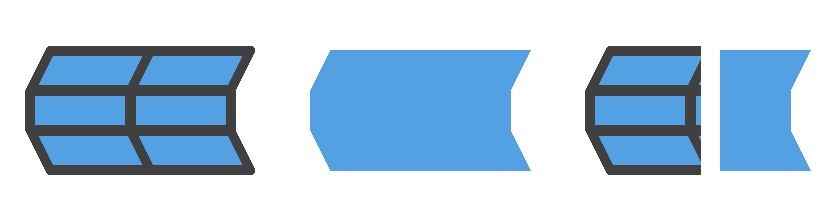

In [10]:
class Mesh(Base):
    def __init__(self, width, height, scale=9, stroke=9, color=None, fill_color=None, background_color=None):
        super().__init__(width, height, scale, stroke, color, fill_color, background_color)
        
    def create(self, mesh=True):

        f00 = Point(5, 5)
        f01 = Point(3, 9)
        f02 = Point(3, 13)
        f03 = Point(5, 17)
        f10 = f00.shift(10, 0)
        f11 = f01.shift(10, 0)
        f12 = f02.shift(10, 0)
        f13 = f03.shift(10, 0)
        f20 = f10.shift(10, 0)
        f21 = f11.shift(10, 0)
        f22 = f12.shift(10, 0)
        f23 = f13.shift(10, 0)
        
        self.face(f00, f01, f11, f10)
        self.face(f01, f02, f12, f11)
        self.face(f02, f03, f13, f12)
        self.face(f10, f11, f21, f20)
        self.face(f11, f12, f22, f21)
        self.face(f12, f13, f23, f22)

        if mesh:
            self.lines(f00, f01, f11, f10, closed=True)
            self.lines(f01, f02, f12, f11, closed=True)
            self.lines(f02, f03, f13, f12, closed=True)
            self.lines(f10, f11, f21, f20, closed=True)
            self.lines(f11, f12, f22, f21, closed=True)
            self.lines(f12, f13, f23, f22, closed=True)

        return self.im

new_im = Image.new('RGBA', (3 * width*scale, height*scale))
x_offset = 0
c = {}
for visible in ["mesh", "no_mesh"]:
    c[visible] = Mesh(width, height, scale, stroke=scale, fill_color=fill_color, color=color, background_color=None)
    c[visible].create(visible == "mesh")
    new_im.paste(c[visible].im, (x_offset,0))
    x_offset += c[visible].im.size[0]
    c[visible].save("./icons/%s.png" % visible)

mixed = Image.new('RGBA', (width*scale, height*scale))
mixed.paste(c["mesh"].im, (0,0), mask=mask1.im)
mixed.paste(c["no_mesh"].im, (0,0), mask=mask2.im)
mixed.save("./icons/mix_mesh.png")

new_im.paste(mixed, (x_offset,0))
new_im

## Empty icon

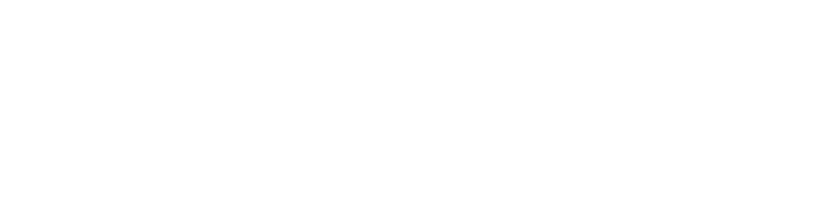

In [11]:
class Empty(Base):

    def __init__(self, width, height, scale=9, stroke=9, color=None, fill_color=None, background_color=None):
        super().__init__(width, height, scale, stroke, color, fill_color, background_color)
        
    def create(self):
        return self.im


new_im = Image.new('RGBA', (3 * width*scale, height*scale))
x_offset = 0
c = Empty(width, height, scale, stroke=scale, fill_color=fill_color, color=color, background_color=None)
c.create()
c.save("./icons/empty.png")

new_im


# Install icons

In [14]:
!rm cq_jupyter/imgs/*

In [209]:
!cp icons/* jupyter_cadquery/icons/